In [1]:
"""Modified Laura's code for internal variability
"""
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
# from tqdm import tqdm
from functools import partial
import json
import tensorflow as tf
from tensorflow.keras import layers
# AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pathlib


2025-06-05 01:25:39.416080: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [37]:
import pandas as pd
import requests
import numpy as np

# URL of the raw data file
url = 'https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/CMIP6_ECS_ERF_fbks.txt'

# Fetch the content from the URL
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Decode the content to a string
data = response.content.decode('utf-8')

# Split the data into lines
lines = data.splitlines()

# Find the line number where the header starts
header_line_index = next(i for i, line in enumerate(lines) if line.startswith('MODEL'))

# Extract the header and data lines
header = lines[header_line_index].split()
data_lines = lines[header_line_index + 1:]

# Create a list of dictionaries for each row
data_dicts = []
for line in data_lines:
    # Split the line into columns based on fixed widths
    model = line[:20].strip()
    variant = line[20:35].strip()
    values = line[35:].split()
    row = [model, variant] + values
    data_dicts.append(dict(zip(header, row)))

# Create the DataFrame
df = pd.DataFrame(data_dicts)

# Display the DataFrame
print(df)


                   MODEL          VARIANT  \
0   --------------------  ---------------   
1             ACCESS-CM2         r1i1p1f1   
2          ACCESS-ESM1-5         r1i1p1f1   
3          AWI-CM-1-1-MR         r1i1p1f1   
4            BCC-CSM2-MR         r1i1p1f1   
5               BCC-ESM1         r1i1p1f1   
6            CAMS-CSM1-0         r1i1p1f1   
7                  CESM2         r1i1p1f1   
8              CESM2-FV2         r1i1p1f1   
9            CESM2-WACCM         r1i1p1f1   
10       CESM2-WACCM-FV2         r1i1p1f1   
11                 CIESM         r1i1p1f1   
12          CMCC-CM2-SR5         r1i1p1f1   
13             CMCC-ESM2         r1i1p1f1   
14            CNRM-CM6-1         r1i1p1f2   
15         CNRM-CM6-1-HR         r1i1p1f2   
16           CNRM-ESM2-1         r1i1p1f2   
17               CanESM5         r1i1p1f1   
18              E3SM-1-0         r1i1p1f1   
19             EC-Earth3         r8i1p1f1   
20     EC-Earth3-AerChem         r1i1p1f1   
21        

In [38]:
df

,MODEL,VARIANT,ECS,ERF2x,PL,PL*,LR,LR*,WV,RH,ALB,CLD,SWCLD,LWCLD,NET,ERR
0,--------------------,---------------,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACCESS-CM2,r1i1p1f1,4.66,3.43,-3.29,-1.91,-0.47,-0.05,1.72,-0.07,0.39,0.76,0.96,-0.20,-0.74,0.15
2,ACCESS-ESM1-5,r1i1p1f1,3.88,2.83,-3.27,-1.91,-0.30,0.02,1.70,0.02,0.46,0.56,0.43,0.13,-0.73,0.12
3,AWI-CM-1-1-MR,r1i1p1f1,3.16,3.63,-3.23,-1.88,-0.41,-0.03,1.77,0.03,0.46,0.22,-0.31,0.53,-1.15,0.04
4,BCC-CSM2-MR,r1i1p1f1,3.02,3.11,-3.31,-1.95,-0.36,0.01,1.67,-0.07,0.43,0.51,0.16,0.35,-1.03,0.04
5,BCC-ESM1,r1i1p1f1,3.25,3.01,-3.29,-1.94,-0.35,0.01,1.66,-0.05,0.47,0.52,0.02,0.50,-0.92,0.07
6,CAMS-CSM1-0,r1i1p1f1,2.29,4.17,-3.31,-1.91,-0.62,-0.05,2.01,0.05,0.26,-0.36,-0.72,0.36,-1.82,0.19
7,CESM2,r1i1p1f1,5.15,3.27,-3.34,-1.93,-0.53,-0.08,1.87,0.00,0.40,0.96,0.79,0.17,-0.63,0.01
8,CESM2-FV2,r1i1p1f1,5.16,2.86,-3.30,-1.92,-0.51,-0.07,1.74,-0.07,0.43,1.06,0.95,0.11,-0.55,0.03
9,CESM2-WACCM,r1i1p1f1,4.68,3.30,-3.34,-1.94,-0.54,-0.07,1.86,-0.01,0.40,1.17,1.05,0.12,-0.71,-0.25


,MODEL,VARIANT,ECS,ERF2x,PL,PL*,LR,LR*,WV,RH,ALB,CLD,SWCLD,LWCLD,NET,ERR
1,ACCESS-CM2,r1i1p1f1,4.66,3.43,-3.29,-1.91,-0.47,-0.05,1.72,-0.07,0.39,0.76,0.96,-0.20,-0.74,0.15
2,ACCESS-ESM1-5,r1i1p1f1,3.88,2.83,-3.27,-1.91,-0.30,0.02,1.70,0.02,0.46,0.56,0.43,0.13,-0.73,0.12
3,AWI-CM-1-1-MR,r1i1p1f1,3.16,3.63,-3.23,-1.88,-0.41,-0.03,1.77,0.03,0.46,0.22,-0.31,0.53,-1.15,0.04
4,BCC-CSM2-MR,r1i1p1f1,3.02,3.11,-3.31,-1.95,-0.36,0.01,1.67,-0.07,0.43,0.51,0.16,0.35,-1.03,0.04
5,BCC-ESM1,r1i1p1f1,3.25,3.01,-3.29,-1.94,-0.35,0.01,1.66,-0.05,0.47,0.52,0.02,0.50,-0.92,0.07
6,CAMS-CSM1-0,r1i1p1f1,2.29,4.17,-3.31,-1.91,-0.62,-0.05,2.01,0.05,0.26,-0.36,-0.72,0.36,-1.82,0.19
7,CESM2,r1i1p1f1,5.15,3.27,-3.34,-1.93,-0.53,-0.08,1.87,0.00,0.40,0.96,0.79,0.17,-0.63,0.01
8,CESM2-FV2,r1i1p1f1,5.16,2.86,-3.30,-1.92,-0.51,-0.07,1.74,-0.07,0.43,1.06,0.95,0.11,-0.55,0.03
9,CESM2-WACCM,r1i1p1f1,4.68,3.30,-3.34,-1.94,-0.54,-0.07,1.86,-0.01,0.40,1.17,1.05,0.12,-0.71,-0.25
10,CESM2-WACCM-FV2,r1i1p1f1,4.80,2.92,-3.31,-1.93,-0.52,-0.07,1.75,-0.09,0.41,1.13,0.97,0.15,-0.61,-0.06


In [35]:
df = df.iloc[1:54]
# Assuming df is already loaded and cleaned


In [36]:
df

,MODEL,VARIANT,ECS,ERF2x,PL,PL*,LR,LR*,WV,RH,ALB,CLD,SWCLD,LWCLD,NET,ERR
5,BCC-ESM1,r1i1p1f1,3.25,3.01,-3.29,-1.94,-0.35,0.01,1.66,-0.05,0.47,0.52,0.02,0.50,-0.92,0.07
6,CAMS-CSM1-0,r1i1p1f1,2.29,4.17,-3.31,-1.91,-0.62,-0.05,2.01,0.05,0.26,-0.36,-0.72,0.36,-1.82,0.19
7,CESM2,r1i1p1f1,5.15,3.27,-3.34,-1.93,-0.53,-0.08,1.87,0.00,0.40,0.96,0.79,0.17,-0.63,0.01
8,CESM2-FV2,r1i1p1f1,5.16,2.86,-3.30,-1.92,-0.51,-0.07,1.74,-0.07,0.43,1.06,0.95,0.11,-0.55,0.03
9,CESM2-WACCM,r1i1p1f1,4.68,3.30,-3.34,-1.94,-0.54,-0.07,1.86,-0.01,0.40,1.17,1.05,0.12,-0.71,-0.25
10,CESM2-WACCM-FV2,r1i1p1f1,4.80,2.92,-3.31,-1.93,-0.52,-0.07,1.75,-0.09,0.41,1.13,0.97,0.15,-0.61,-0.06
11,CIESM,r1i1p1f1,5.63,3.86,-3.25,-1.89,-0.35,-0.01,1.60,-0.10,0.29,0.81,0.68,0.13,-0.69,0.21
12,CMCC-CM2-SR5,r1i1p1f1,3.55,3.79,-3.32,-1.92,-0.47,-0.04,1.82,-0.01,0.34,0.52,0.48,0.04,-1.07,0.04
13,CMCC-ESM2,r1i1p1f1,3.58,3.75,-3.31,-1.92,-0.47,-0.04,1.84,0.02,0.37,0.50,0.45,0.05,-1.05,0.03
14,CNRM-CM6-1,r1i1p1f2,4.90,3.64,-3.29,-1.92,-0.42,-0.01,1.75,-0.02,0.53,0.55,-0.02,0.57,-0.74,0.13


In [40]:
df = df.iloc[1:54]
df['ECS'] = np.array(df['ECS'], dtype =float)
df = df.sort_values(by='ECS')


/tmp/ipykernel_247206/3283668720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ECS'] = np.array(df['ECS'], dtype =float)


In [28]:
df['ECS'].max()

'5.64'

/tmp/ipykernel_247206/960780637.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_list['RCM Ensemble'] = new_list[['MODEL','ECS']].T.apply(lambda a: f(a, array_true = highlight_a))
/tmp/ipykernel_247206/960780637.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_list['GAN Ensemble'] = new_list[['MODEL','ECS']].T.apply(lambda a: f(a, array_true = highlight_b))
/tmp/ipykernel_247206/960780637.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklab

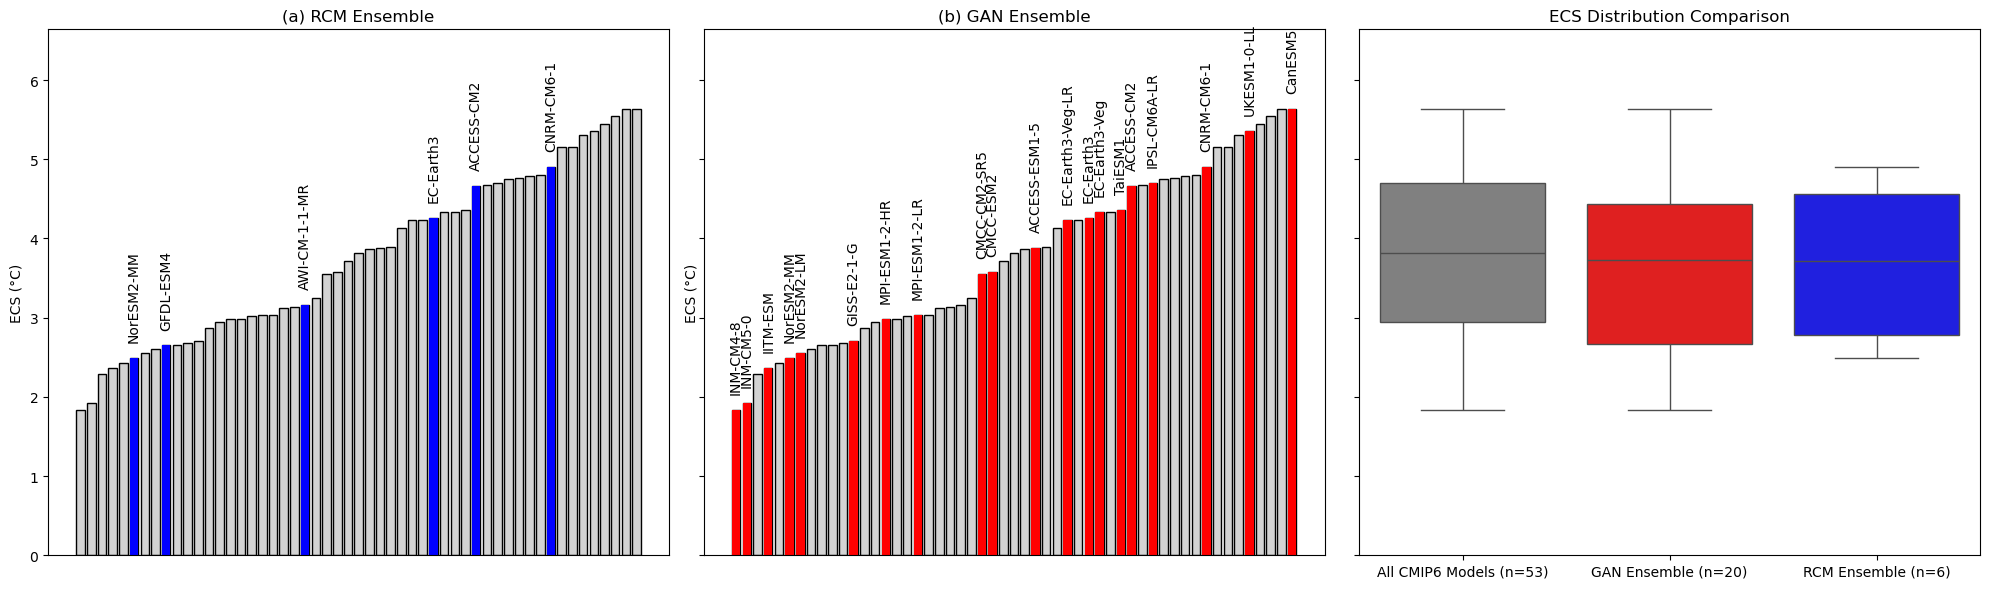

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is already loaded and cleaned


# Define highlighted GCMs
highlight_a = {"NorESM2-MM", "GFDL-ESM4", "AWI-CM-1-1-MR", "EC-Earth3", "ACCESS-CM2", "CNRM-CM6-1"}
highlight_b = {"MPI-ESM1-2-HR", "ACCESS-CM2", "ACCESS-ESM1-5", "GISS-E2-1-G", "INM-CM4-8", "INM-CM5-0", "EC-Earth3", "TaiESM1", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "NorESM2-LM", "NorESM2-MM", "CanESM5", "UKESM1-0-LL", "IITM-ESM", "CMCC-ESM2", "EC-Earth3-Veg-LR", "CNRM-CM6-1", "EC-Earth3-Veg", "CMCC-CM2-SR5"}

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey =True)

# Panel (a): Highlight 6 models
axes[0].bar(range(len(df)), df['ECS'], color="lightgray", edgecolor="black")
for i, model in enumerate(df['MODEL']):
    if model in highlight_a:
        axes[0].bar(i, df['ECS'].iloc[i], color="blue")
        axes[0].text(i, df['ECS'].iloc[i] + 0.2, model, ha='center', va='bottom', rotation=90, fontsize=10)
axes[0].set_ylabel("ECS (°C)")
axes[0].set_xticks([])
axes[0].set_title("(a) RCM Ensemble")
axes[0].set_ylim(0, df['ECS'].max() + 1)

# Panel (b): Highlight 20 models
axes[1].bar(range(len(df)), df['ECS'], color="lightgray", edgecolor="black")
for i, model in enumerate(df['MODEL']):
    if model in highlight_b:
        axes[1].bar(i, df['ECS'].iloc[i], color="red")
        axes[1].text(i, df['ECS'].iloc[i] + 0.2, model, ha='center', va='bottom', rotation=90, fontsize=10)
axes[1].set_ylabel("ECS (°C)")
axes[1].set_xticks([])
axes[1].set_title("(b) GAN Ensemble")
axes[1].set_ylim(0, df['ECS'].max() + 1)

new_list = df[['ECS','MODEL']]
def f(a, array_true):
    #print(a.shape)
    if a[0] in array_true:
        return a[1]
    else:
        return np.nan
new_list['RCM Ensemble'] = new_list[['MODEL','ECS']].T.apply(lambda a: f(a, array_true = highlight_a))
new_list['GAN Ensemble'] = new_list[['MODEL','ECS']].T.apply(lambda a: f(a, array_true = highlight_b))
#new_list['ECS_b'] = new_list[['MODEL','ECS']].apply(f)
# Distribution Comparison
sns.boxplot(data=new_list[['ECS','GAN Ensemble', 'RCM Ensemble']],
            ax=axes[2], palette=["gray", "red", "blue"])
axes[2].set_xticklabels(["All CMIP6 Models (n=53)", "GAN Ensemble (n=20)", "RCM Ensemble (n=6)"])
#axes[2].set_ylabel("ECS (°C)")
axes[2].set_title("ECS Distribution Comparison")

plt.tight_layout()
plt.show()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/ECS_spread.png', dpi =500, bbox_inches='tight')

In [9]:
z * 1e-5

1.7757703604752624e-06

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-06-05 01:26:21.204507: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2025-06-05 01:26:21.211004: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-06-05 01:26:21.220130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-06-05 01:26:21.220175: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-06-05 01:26:21.753654: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-06-05 01:26:21.753734: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2025-06-05 01:26:21.930487: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library 

In [3]:

GAN_flag = True
variable = "pr"
input_data_path_base = "/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed"
gcm = "ACCESS-CM2"
ssp = "ssp370"
variant = "r4i1p1f1"
output_path_setup = "/nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/"
emulator_type = "perfect_emulator"
code_dir = "/nesi/project/niwa03712/queenle/ML_emulator"

sys.path.append(f'{code_dir}/code/applying_ml_model/v3')
os.chdir(code_dir)
#try:
from src.util_functions import *
sys.path.append(f'/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/')
from src.layers import *
from src.models import *
from src.gan import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:


configs = {"sfcWind": "NIWA-REMS_sfcWind_v050425",
           "sfcWindmax": "NIWA-REMS_sfcWindmax_v050425",
           "tasmax": "NIWA-REMS_tasmax_v050425",
           "tasmin": "NIWA-REMS_tasmin_v050425",
           "pr": "NIWA-REMS_pr_v050425"}
    
method = 'basic' # method of preprocessing input data
'''
Define config file and directories
'''
framework = "imperfect"
# define directories
ground_truth_dir = '/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/'

print('BEGINNING EMULATOR DOWNSCALING')
# Loading up the minimum value dataset
print('Variable: ' + variable + os.getcwd())
ml_model_name = configs[variable]
print(f"current path: {os.getcwd()}, code_dir: {code_dir}")
min_value = None#xr.open_dataset(r'./models/' + ml_model_name + '/min_value_outputs.nc')


BEGINNING EMULATOR DOWNSCALING
Variable: pr/scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator
current path: /scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator, code_dir: /nesi/project/niwa03712/queenle/ML_emulator


In [5]:
print(input_data_path_base, gcm, ssp,
                                    variant, output_path_setup, variable, configs)
input_file2, output_path = get_files(input_data_path_base, gcm, ssp,
                                    variant, output_path_setup, variable, configs)

/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed ACCESS-CM2 ssp370 r4i1p1f1 /nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/ pr {'sfcWind': 'NIWA-REMS_sfcWind_v050425', 'sfcWindmax': 'NIWA-REMS_sfcWindmax_v050425', 'tasmax': 'NIWA-REMS_tasmax_v050425', 'tasmin': 'NIWA-REMS_tasmin_v050425', 'pr': 'NIWA-REMS_pr_v050425'}


In [6]:
input_file2

'/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp370/r4i1p1f1/day/ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r4i1p1f1_day_gn_v20210712.nc'

In [14]:
ml_model_name = 'NIWA-REMS_v110425_pr'

In [8]:
df2 = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/model00_exp0000.daily.nc').rename({"lev":"plev"})

In [12]:
model_dir ='/nesi/project/niwa03712/queenle/ML_emulator/models/'
#model_dir = './models/'
#ml_model_name ='/new_model_v8_04_25_ACCESS-CM2_0.005pr_ACCESS-CM2_0.01pr_ACCESS-CM2/'
generator, unet_model = load_model(ml_model_name, model_dir)

2025-06-05 02:00:09.283250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-06-05 02:00:09.284114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-06-05 02:00:09.285014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-06-05 02:00:09.285794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-06-05 02:00:09.285858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-06-05 02:00:09.285864: I t

In [13]:

def convert_file(path):
    df2 = xr.open_dataset(path).rename({"lev":"plev"})
    df2 = df2.sel(time = slice("2095","2100"))
    df2.to_netcdf(path.replace(".nc","_updated.nc"))
input_file = r'/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/model00_exp0000.daily_v2.nc'
df2 = xr.open_dataset(input_file2)

In [11]:
# config['train_x']

UsageError: Invalid config statement: "['train_x']", should be `Class.trait = value`.


In [30]:
df = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/data/model00_exp0000.daily.nc')

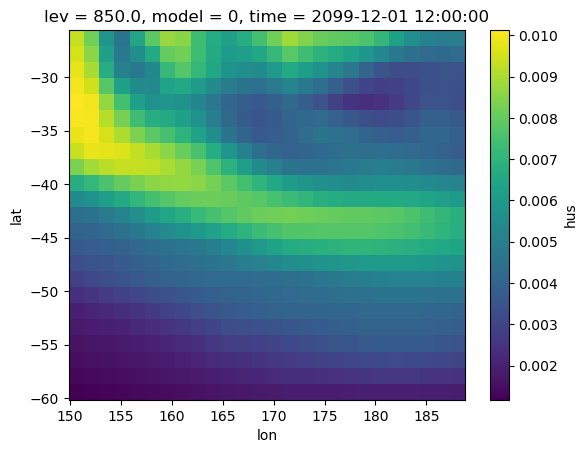

In [35]:
df.hus.isel(time=-1, lev =1).plot()

In [37]:
df2 = xr.open_dataset(config["train_x"])

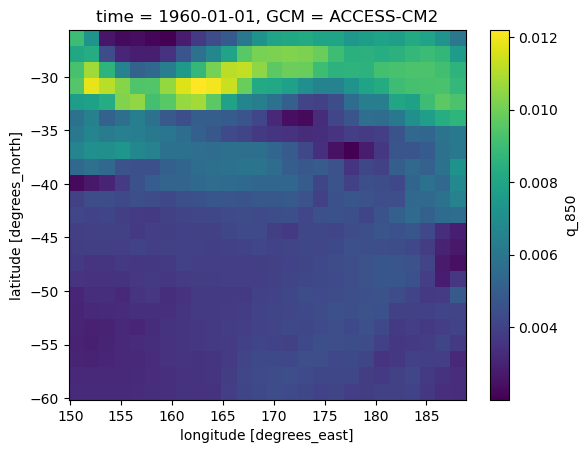

In [39]:
df2.q_850.isel(time =0, GCM =0).plot()

In [15]:
# train_x = xr.open_dataset(config['train_x'])

In [17]:
# train_x.isel(GCM =0, time =558).t_850.plot()

In [18]:
# df2 = xr.open_dataset(input_file).rename({"lev":"plev"})
# df2.to_netcdf(r'/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/model00_exp0000.daily_v2.nc')

In [19]:
df2 = xr.open_dataset(input_file2)

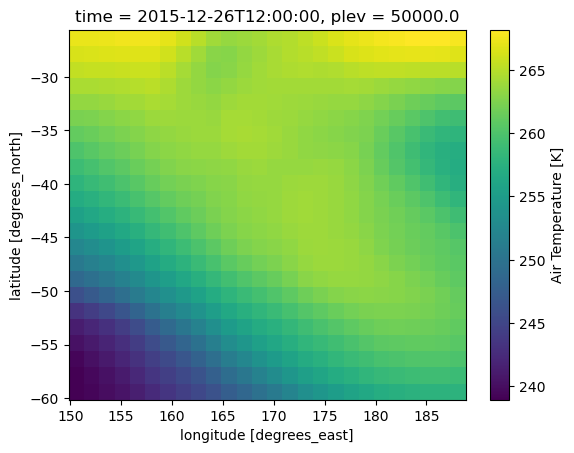

In [20]:
df2.ta.isel(plev =1, time =359).plot()

In [22]:
# df.hus.isel(plev =1, time =559).plot()

In [23]:
# plt.plot(df.ta.isel( plev =1).mean(["lat","lon"]).values)#.plot()

In [24]:



config_file = model_dir + ml_model_name + '/config_info.json'
with open(config_file) as f:
    config = json.load(f)

output_means = xr.open_dataset(config["means_output"])
output_stds = xr.open_dataset(config["stds_output"])
# LOAD ML MODEL
print('LOAD ML MODEL\n')

# PREP INPUT
print('\nPREP INPUT')
processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                               framework, method = method)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 7.57 ss
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array


In [9]:
files = glob.glob(r'/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/data/model00_*.daily.nc')

In [20]:
files[0].split('.')[0].split('_')[-1]


'exp0006'

In [22]:
preds = []
exps = []
for file in files:
    
    # lets first convert the files
    def convert_file(path):
        df2 = xr.open_dataset(path).rename({"lev":"plev"})
        df2 = df2.sel(time = slice("2095","2100"))
        try:
            df2.to_netcdf(path.replace(".nc","_updated.nc"))
        except:
            print("file_exists")
    exp = file.split('.')[0].split('_')[-1]
    convert_file(file)
    # now change the file name
    input_file2 = file.replace(".nc","_updated.nc")
    # update file ane
    
    config_file = model_dir + ml_model_name + '/config_info.json'
    with open(config_file) as f:
        config = json.load(f)

    output_means = xr.open_dataset(config["means_output"])
    output_stds = xr.open_dataset(config["stds_output"])
    # LOAD ML MODEL
    print('LOAD ML MODEL\n')

    # PREP INPUT
    print('\nPREP INPUT')
    processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                                   framework, method = method)
    
    with ProgressBar():
        mean_data = mean_data.load()
        variance_data = variance_data.load()
        processed_GCM_data = processed_GCM_data.load()
        time_of_year = time_of_year.load()
        print(mean_data, time_of_year)
    print('PREP OUTPUT')
    output_shape = initialize_output_ds(processed_GCM_data, config)
    output_shape = output_shape.rename({"pr": variable})
# APPLY MODEL
    print('APPLY ML MODEL')
    ts = slice("2095","2100")
    output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                        processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                     'channel').sel(time = ts).values, \
                                                        output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                        mean_data.sel(time = ts).transpose('time', 'channel'),
                                                        variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                        min_value=min_value, varname=variable)
    output2.to_netcdf(input_file2.replace(".nc", "_downscaled.nc"))
    preds.append(output2)
    exps.append(exp)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 1.41 sms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.50501659,  2.27845242,  1.83193279, ...,  0.83175026,
         1.68469282,  1.74482612],
       [ 2.19625623,  2.00416495,  1.44749451, ...,  0.61725554,
         1.13737614,  1.38635388],
       [-0.81788639, -0.56027142, -0.60792444, ...,  1.73834804,
         1.63488673,  1.85696695],
       ...,
       [-0.42863878,  0.39933449,  1.28105031, ..., -0.02824987,
        -0.53716635, -0.6544378 ],
       [ 0.59183374,  0.68062823,  0.69833546, ...,  0.36168936,
         0.72966835,  0.71934527],
       [ 1.11758616,  1.06371114,  0.95848988, ...,  0.12386982,
         0.

Predicting: 100%|██████████| 28/28 [00:31<00:00,  1.14s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.72 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.74691088,  2.52123139,  2.07559645, ...,  1.03349268,
         1.88799423,  1.94968651],
       [ 2.44017573,  2.24871462,  1.69267432, ...,  0.83517595,
         1.35661477,  1.60691074],
       [-0.75942483, -0.50200908, -0.54986133, ...,  1.79543342,
         1.69222564,  1.91455939],
       ...,
       [-0.43097714,  0.39699518,  1.27871006, ..., -0.03052343,
        -0.53944676, -0.65672506],
       [ 0.79285976,  0.88192425,  0.89990147, ...,  0.55704515,
         0.92541657,  0.91548592],
       [ 1.31573488,  1.26195856,  1.15683601, ...,  0.31885125,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.58 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.67142129,  2.44546593,  1.99955512, ...,  0.97078856,
         1.82480559,  1.88601335],
       [ 2.36405412,  2.17239656,  1.61615983, ...,  0.76744349,
         1.28847264,  1.53835892],
       [-0.77766932, -0.52019136, -0.56798139, ...,  1.77769055,
         1.67440398,  1.89665895],
       ...,
       [-0.43024739,  0.39772522,  1.27944039, ..., -0.02981678,
        -0.53873798, -0.65601415],
       [ 0.73012421,  0.81910461,  0.83699774, ...,  0.49632605,
         0.86457555,  0.85452297],
       [ 1.25389727,  1.20009031,  1.09493712, ...,  0.25824851,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.95 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 1.87788873,  1.64902377,  1.20020335, ...,  0.29282506,
         1.14159823,  1.19756213],
       [ 1.56387785,  1.37014583,  0.81183465, ...,  0.03511385,
         0.55170755,  0.79715838],
       [-0.9694521 , -0.71132201, -0.75845991, ...,  1.58585315,
         1.48171307,  1.70311453],
       ...,
       [-0.42257639,  0.40539939,  1.28711772, ..., -0.02217641,
        -0.53107453, -0.64832762],
       [ 0.07065972,  0.15874867,  0.17575035, ..., -0.160173  ,
         0.20675214,  0.1953752 ],
       [ 0.60387173,  0.54973546,  0.44425296, ..., -0.39699253,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.17s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.57 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.0280689 ,  1.79975474,  1.35148513, ...,  0.42433447,
         1.27412585,  1.33110797],
       [ 1.71531537,  1.5219761 ,  0.96405766, ...,  0.17716891,
         0.69462416,  0.94093654],
       [-0.93315621, -0.67514951, -0.7224108 , ...,  1.62306515,
         1.51909095,  1.74065829],
       ...,
       [-0.42402817,  0.40394701,  1.28566474, ..., -0.02365847,
        -0.53256107, -0.64981865],
       [ 0.1954668 ,  0.28372458,  0.30089509, ..., -0.0328276 ,
         0.33435561,  0.32323675],
       [ 0.72689245,  0.67281861,  0.56739854, ..., -0.26989115,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.53 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.41068143,  2.18377301,  1.73690914, ...,  0.75264805,
         1.60497911,  1.66450089],
       [ 2.10113127,  1.90879499,  1.35187955, ...,  0.53181006,
         1.05141352,  1.29987411],
       [-0.84068553, -0.58299272, -0.63056789, ...,  1.71596516,
         1.61240436,  1.83438511],
       ...,
       [-0.42772685,  0.40024678,  1.28196296, ..., -0.02735842,
        -0.53627221, -0.65354097],
       [ 0.51343659,  0.6021264 ,  0.61972894, ...,  0.28509142,
         0.65291626,  0.64243903],
       [ 1.04031112,  0.98639818,  0.88113901, ...,  0.04741867,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.67 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.59098675,  2.36473711,  1.91853201, ...,  0.90371843,
         1.75721719,  1.81790668],
       [ 2.28294616,  2.09107895,  1.53463258, ...,  0.69499492,
         1.21558584,  1.4650339 ],
       [-0.79710893, -0.53956474, -0.58728854, ...,  1.75871227,
         1.65534142,  1.87751211],
       ...,
       [-0.42946984,  0.39850309,  1.28021857, ..., -0.02906093,
        -0.53797985, -0.65525374],
       [ 0.66327916,  0.7521697 ,  0.76997297, ...,  0.43137919,
         0.79949824,  0.78931521],
       [ 1.18800898,  1.13416912,  1.02898303, ...,  0.19342611,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.16s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.54 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.30218904,  2.07488536,  1.62762623, ...,  0.66144592,
         1.51307165,  1.57188811],
       [ 1.99173054,  1.79911314,  1.24191656, ...,  0.43329438,
         0.95230128,  1.20016532],
       [-0.86690622, -0.60912375, -0.65660927, ...,  1.69015848,
         1.5864829 ,  1.80834886],
       ...,
       [-0.42667806,  0.40129598,  1.28301257, ..., -0.02633061,
        -0.5352413 , -0.65250695],
       [ 0.42327409,  0.51184399,  0.52932663, ...,  0.19677673,
         0.56442353,  0.55376825],
       [ 0.95143912,  0.89748306,  0.79218077, ..., -0.04072679,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.59 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 1.64062703,  1.41088536,  0.96118823, ...,  0.08155616,
         0.92869237,  0.98301931],
       [ 1.32462971,  1.13027084,  0.5713328 , ..., -0.19309642,
         0.32211184,  0.56617724],
       [-1.02679405, -0.76847029, -0.81541452, ...,  1.52607243,
         1.42166548,  1.64280007],
       ...,
       [-0.42028281,  0.40769398,  1.28941331, ..., -0.01979551,
        -0.52868639, -0.64593225],
       [-0.1265164 , -0.03869924, -0.02196934, ..., -0.36475198,
         0.00175718, -0.01003575],
       [ 0.40951781,  0.35527803,  0.24969202, ..., -0.60117951,
        -0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.47 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.1743216 ,  1.9465501 ,  1.49882314, ...,  0.55264752,
         1.40343161,  1.46140643],
       [ 1.86279255,  1.66984187,  1.11231202, ...,  0.31577141,
         0.83406639,  1.0812185 ],
       [-0.89780952, -0.63992177, -0.68730201, ...,  1.65937276,
         1.55556017,  1.77728912],
       ...,
       [-0.42544198,  0.40253256,  1.28424965, ..., -0.0251045 ,
        -0.53401148, -0.65127343],
       [ 0.31700998,  0.40543702,  0.42277681, ...,  0.09142294,
         0.45885708,  0.44798914],
       [ 0.84669596,  0.7926876 ,  0.68733301, ..., -0.14587869,
         0

Predicting: 100%|██████████| 28/28 [00:31<00:00,  1.14s/batch]


In [23]:
preds = xr.concat(preds, dim ="exp")

In [25]:
preds['exp'] = (('exp'), exps)

In [62]:
preds = preds.reindex(exp = sorted(preds.exp.values))

In [27]:
rx1day = preds.groupby('time.year').max().mean("year")

In [33]:
sorted(exps)

['exp0000',
 'exp0001',
 'exp0002',
 'exp0003',
 'exp0004',
 'exp0005',
 'exp0006',
 'exp0007',
 'exp0008',
 'exp0009']

In [38]:
dset = rx1day.reindex(exp = sorted(rx1day.exp.values))

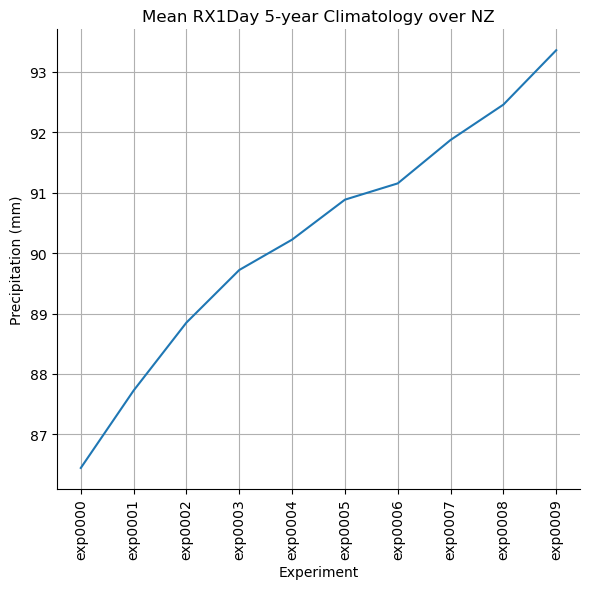

In [103]:
fig, ax = plt.subplots(figsize = (6, 6))
dset.where(orog>0, np.nan).mean(["lat","lon"]).pr.plot(ax = ax)
ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Experiment")
ax.set_title("Mean RX1Day 5-year Climatology over NZ", fontsize=12)
ax.grid('on')
plt.tight_layout()
fig.show()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/figures/rx1day.png', dpi =300, bbox_inches ='tight')

In [56]:
preds.sel(exp = 'exp0000').mean(["lat","lon"]).pr.argmax()

<xarray.DataArray 'pr' ()>
array(1554)
Coordinates:
    GCM      <U10 'ACCESS-CM2'
    exp      <U7 'exp0000'

In [65]:
preds.isel(time =1554).max(["lat","lon"])

<xarray.Dataset>
Dimensions:      (exp: 10)
Coordinates:
  * exp          (exp) <U7 'exp0000' 'exp0001' 'exp0002' ... 'exp0008' 'exp0009'
    GCM          <U10 'ACCESS-CM2'
    time         object 2099-04-05 12:00:00
Data variables:
    pr           (exp) float64 193.5 207.0 220.3 227.0 ... 238.4 235.6 242.2
    pr_GAN_mask  (exp) int64 0 0 0 0 0 0 0 0 0 0

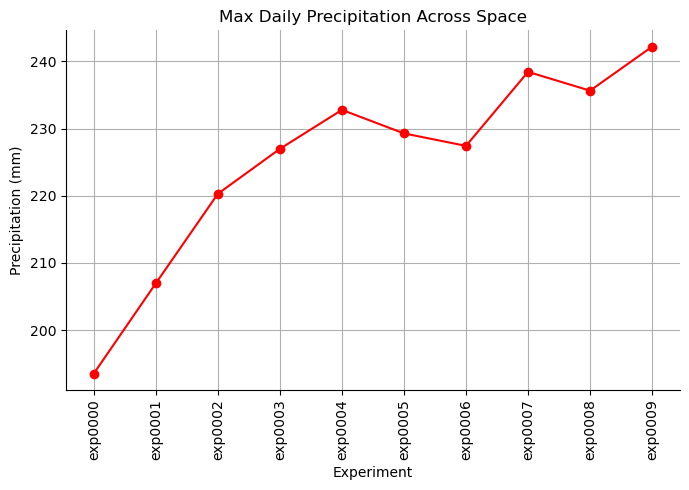

In [100]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

# Plot the maximum precipitation across space
preds.isel(time=1554).max(["lat", "lon"]).pr.plot(ax=ax, marker ='o', color ='r')

# Improve plot appearance
ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Experiment")
ax.set_title("Max Daily Precipitation Across Space", fontsize=12)
ax.grid('on')
plt.tight_layout()

fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/figures/precipitation_for_a_case_study_max_precip.png', dpi =300, bbox_inches ='tight')

plt.show()

In [95]:
preds.sel(exp=exp).isel(time=1554)

<xarray.Dataset>
Dimensions:      (lat: 172, lon: 179)
Coordinates:
    exp          <U7 'exp0009'
  * lon          (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat          (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM          <U10 'ACCESS-CM2'
    time         object 2099-04-05 12:00:00
Data variables:
    pr           (lat, lon) float64 1.138 1.22 1.186 1.266 ... 0.0 0.1344 0.0
    pr_GAN_mask  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

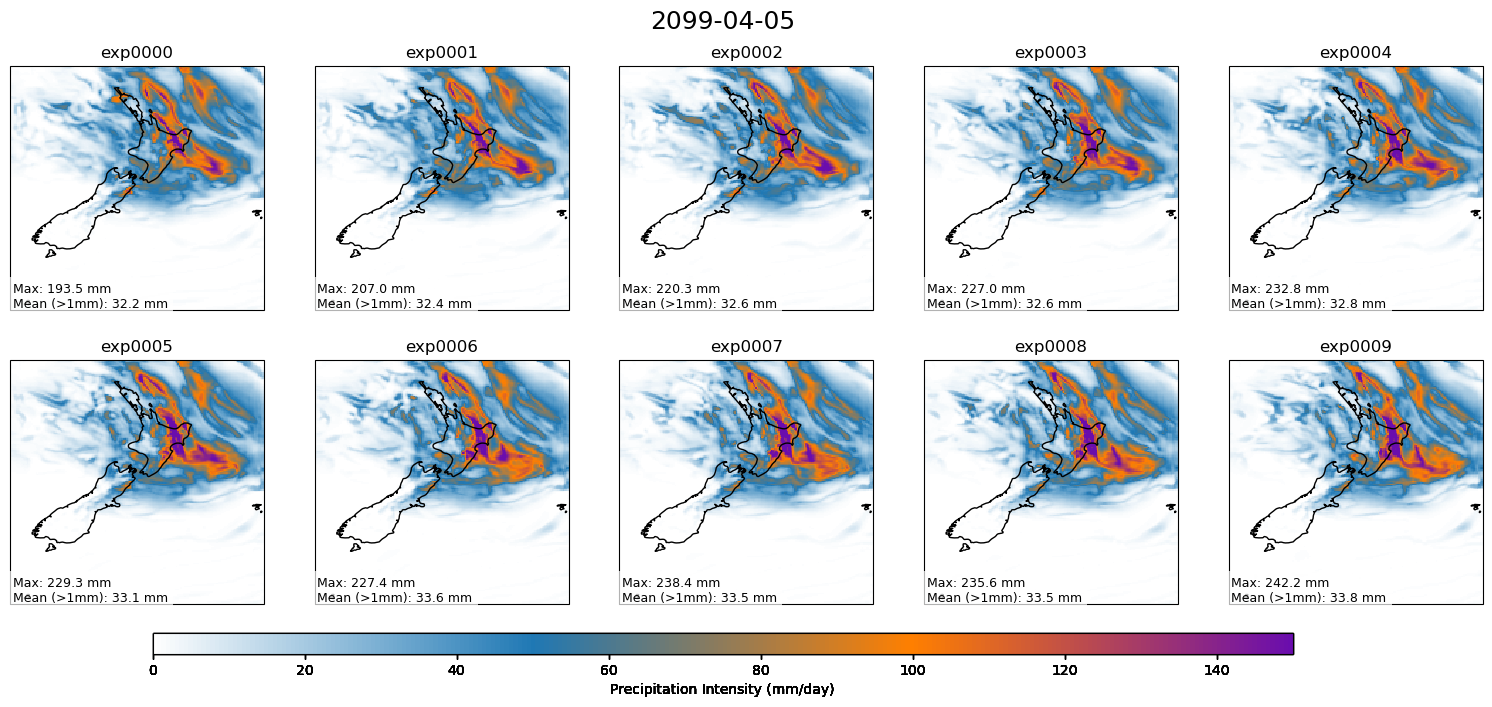

In [99]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import numpy as np

# Define a custom colormap: white (low) → blue → orange → purple (high)
colors = ["#ffffff", "#1f78b4", "#ff7f00", "#6a0dad"]  # white, blue, orange, purple
cmap = mcolors.LinearSegmentedColormap.from_list("white_blue_orange_purple", colors)

# Create the facet plot
fig, axes = plt.subplots(
    nrows=2, ncols=5,
    figsize=(19, 7),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=171.77)}
)

axes = axes.flatten()

# Loop over experiments
for i, exp in enumerate(preds.exp.values):
    data = preds.sel(exp=exp).isel(time=1554).pr
    pr_values = data.values

    # Compute max and mean (where pr > 1 mm/day)
    max_pr = np.nanmax(pr_values)
    mean_pr = np.nanmean(pr_values[pr_values > 1.0])

    # Plot the data
    im = data.plot(
        ax=axes[i],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmax=150,
        add_colorbar=False,
    )
    axes[i].coastlines()
    axes[i].set_title(str(exp))

    # Annotate statistics
    axes[i].text(
        0.01, 0.01,
        f"Max: {max_pr:.1f} mm\nMean (>1mm): {mean_pr:.1f} mm",
        transform=axes[i].transAxes,
        fontsize=9,
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    cbarax=fig.add_axes([0.2, 0.04, 0.6, 0.03])
    cbar = fig.colorbar(im, cax = cbarax, orientation ='horizontal')
    cbar.set_label('Precipitation Intensity (mm/day)')
    fig.suptitle('2099-04-05', x =0.5, y=0.96, fontsize =18)
    fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/GCM_emulator/figures/precipitation_for_a_case_study.png', dpi =300, bbox_inches ='tight')


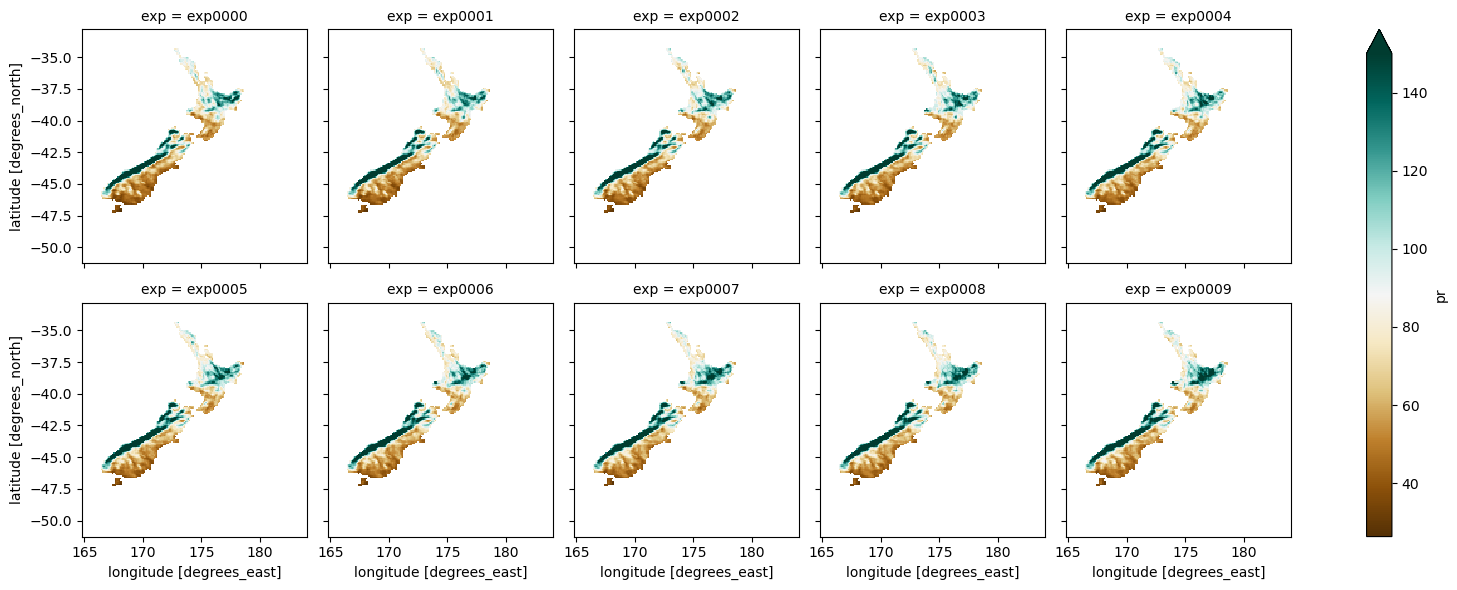

In [50]:
dset.pr.where(orog>0, np.nan).plot(col ="exp", col_wrap =5, vmax =150, cmap ='BrBG')

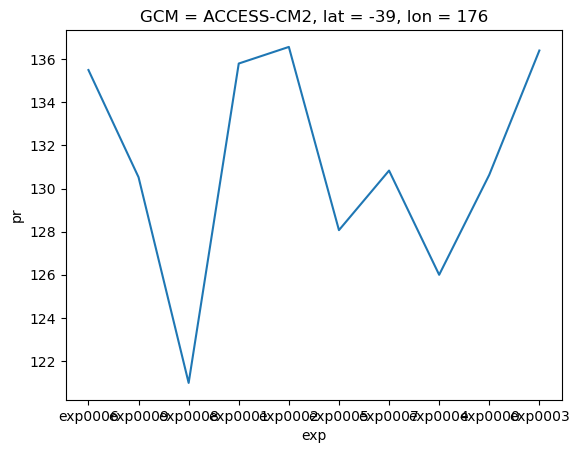

In [31]:
rx1day.interp(lat =-39, lon =176, method ='nearest').pr.plot()

In [25]:

# PREP OUTPUT

with ProgressBar():
    mean_data = mean_data.load()
    variance_data = variance_data.load()
    processed_GCM_data = processed_GCM_data.load()
    time_of_year = time_of_year.load()
    print(mean_data, time_of_year)
print('PREP OUTPUT')
output_shape = initialize_output_ds(processed_GCM_data, config)
output_shape = output_shape.rename({"pr": variable})


<xarray.DataArray 'q_500' (channel: 8, time: 31411)>
array([[ 4.5549873e-01, -2.3507118e-02,  4.5244321e-01, ...,
         1.5300345e+00,  2.4468446e+00,  3.6205027e+00],
       [ 2.1126568e-01, -2.6527923e-01, -3.0036268e-01, ...,
         1.9098775e+00,  2.5087149e+00,  3.3172333e+00],
       [ 3.1234252e-01,  2.5087810e-01,  2.7895106e-02, ...,
        -2.0575432e-01, -5.8768141e-01, -9.0680468e-01],
       ...,
       [ 3.4481615e-01,  1.1446120e+00,  8.0104285e-01, ...,
         3.8201907e-01, -7.0132202e-01, -2.1661975e+00],
       [ 8.4645584e-02, -1.4468497e-01, -1.1675495e-03, ...,
         1.5886772e+00,  1.7362022e+00,  2.1141305e+00],
       [ 9.1751933e-01,  7.4371672e-01,  7.0101881e-01, ...,
         5.0441068e-01,  1.0654876e+00,  1.9273919e+00]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * channel  (channel) <U5 'q_500' 'q_850' 'u_500' ... 'v_850' 't_500' 't_850' <xarray.DataArray 'dayofyear' (time: 314

In [26]:
# APPLY MODEL
print('APPLY ML MODEL')
ts = slice("2015","2040")
output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                    processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                 'channel').sel(time = ts).values, \
                                                    output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                    mean_data.sel(time = ts).transpose('time', 'channel'),
                                                    variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                    min_value=min_value, varname=variable)



APPLY ML MODEL


Predicting:   0%|          | 0/148 [00:00<?, ?batch/s]2025-06-03 02:23:37.415334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-06-03 02:23:37.424367: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2025-06-03 02:23:38.215724: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-06-03 02:23:38.626151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2025-06-03 02:23:40.335474: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-06-03 02:23:40.576855: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
Predicting: 100%|██████████| 148/148 [03:26<00:00,  1.39s/batch]


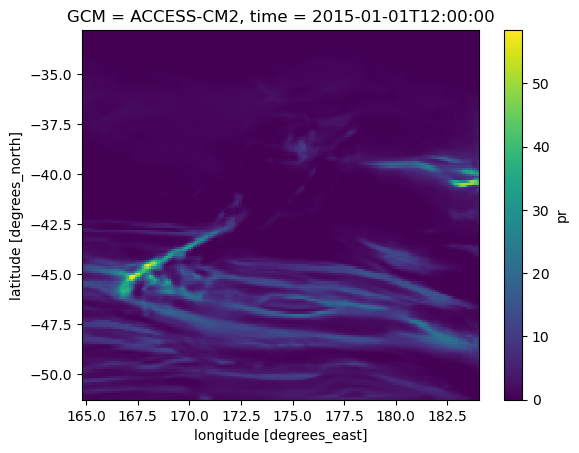

In [43]:
output2.isel(time =0).pr.plot()

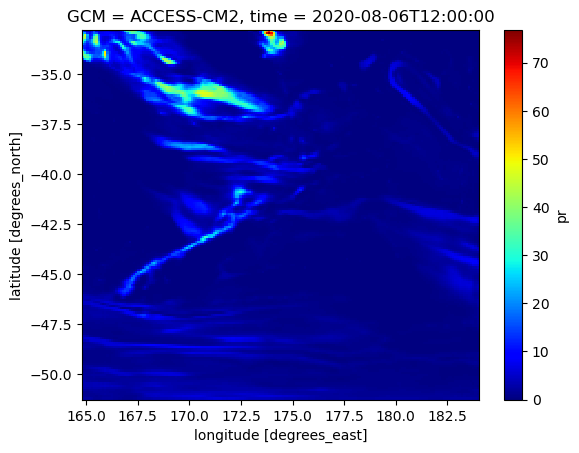

In [244]:
output2.isel(time =-148).pr.plot(cmap ='jet')

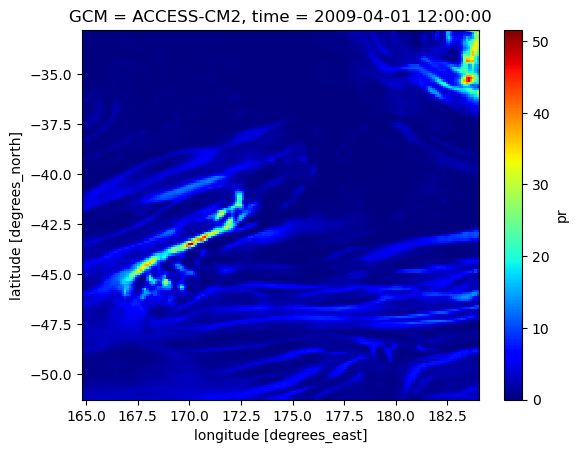

In [237]:
output.isel(time =1185).pr.plot(cmap ='jet')

In [69]:
climo = output.groupby('time.season').mean()

In [173]:
climo2 = output2.groupby('time.season').mean()

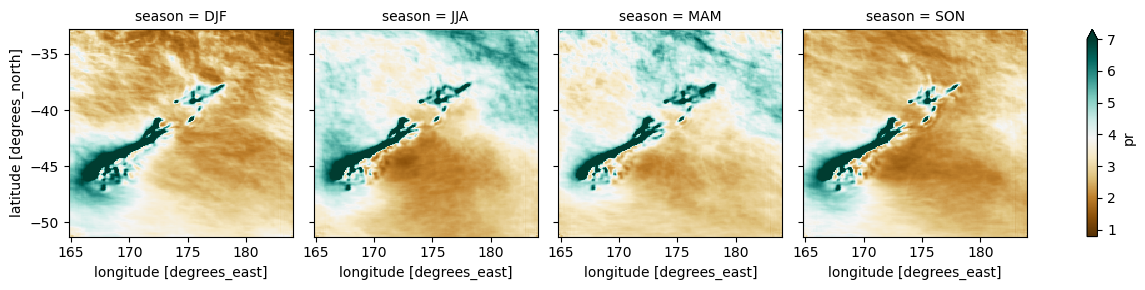

In [174]:
climo2.pr.plot(col ="season", vmax =7, cmap ='BrBG')

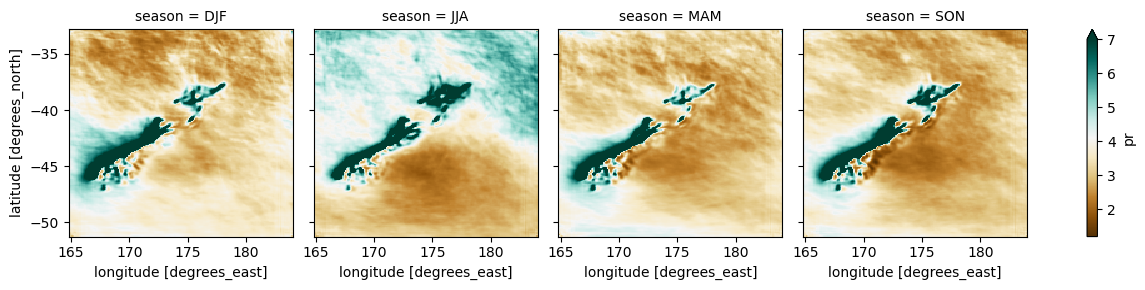

In [70]:
climo.pr.plot(col ="season", vmax =7, cmap ='BrBG')